In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import os
import sys
import scipy.linalg
import scipy.stats
import importlib

#### Load data

In [2]:
# read in posterior
posterior = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/posterior0.csv")
# load some files maybe
# recombination map (in morgan)
recoMap = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/map.csv", delimiter=',')
print (recoMap.shape)
# readcounts for target individual
# first line: reads for ref; second line: reads for alt
target = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/readcounts.csv", delimiter=',')
print (target.shape)
numSnps = target.shape[1]
# read in references
# 0 in refHaps is refAllele
refHaps = numpy.loadtxt ("/Users/steinrue/googleDrive/misc/data_matthias/refs.csv", delimiter=',')
print (refHaps.shape)
# get some truth
truthTable = pandas.read_csv ("/Users/steinrue/googleDrive/misc/data_matthias/roh_gt.csv", sep='\t')

(38032,)
(2, 38032)
(792, 38032)


In [3]:
# make a truth vector
truth = numpy.zeros (numSnps)
beginnings = numpy.searchsorted (recoMap, truthTable["ROH_Begin"])
ends = numpy.searchsorted (recoMap, truthTable["ROH_End"])
assert (len(beginnings) == len(ends))
for i in range(len(beginnings)):
    truth [beginnings[i]:ends[i]] = 1

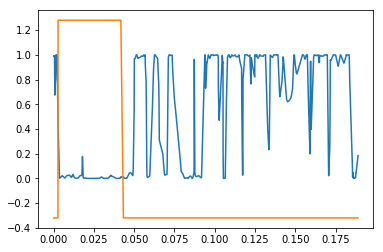

In [4]:
daRange = numpy.arange(0,2000)
xs = recoMap[daRange]
plt.plot (xs, numpy.exp(posterior[daRange]))
plt.plot (xs, (truth[daRange]-0.2)*1.6)

#### Try to run hapsburg

In [5]:
# make it small for now, so we see what we are doing
# numHaps = 10
# numLoci = 20
# refHaps = refHaps[0:10,0:20]
# target = target[:,0:20]
# recoMap = recoMap[0:20]

# refHaps = refHaps[360:380,:]

In [6]:
# get the path right, for some reason cython makes trouble
sys.path.append("../../Python3/")
sys.path.append("../../Python3/Python3/")
sys.path.append("../../PackagesSupport/loadEigenstrat/")

In [7]:
# get the fwd,bwd algorithm (fast is using grouping of haps in RHO state)
from cfunc import fwd_bkwd_fast, print_memory_usage
from hmm_inference import HMM_Analyze, prep_3x3matrix, exponentiate_r
from transitions import load_transition_model
from emissions import load_emission_model

In [8]:
%%time
# set up all the necessary stuff
n_ref = refHaps.shape[0]

# prepare the recombination map
# fake using a member function of class HMM_Analyze
blub = type('', (), {})()
blub.r_map = recoMap
blub.output = False
r_map = HMM_Analyze.prepare_rmap (self=blub)

# initial probability to copy from one individual
# I guess that means intial prob. for ROH state?
# no, it's actually p(roh) * n_ref
in_val = 1e-4

# transition
# prepare single-step transition (the 3 rates are hardcoded in this)
t_obj = load_transition_model ("model", n_ref)
# some default params
# t_obj.set_params(roh_in=1, roh_out=10, roh_jump=100)
t_obj.set_params(roh_in=100, roh_out=100, roh_jump=300)
# this gives only a 3x3 
t_mat = t_obj.give_transitions()
# pre-compute the t_mat at all loci
t_mat_full = HMM_Analyze.pre_compute_transition_matrix (self=None, t=t_mat, r_vec=r_map, n_ref=n_ref)

# emission
# the error rates seem to be somewhat hardcoded, but can be changed
e_obj = load_emission_model (refHaps, "readcount")
# setattr (e_obj, "e_rate", 1e-2)
# setattr (e_obj, "e_rate_ref", 1e-3)
# prepare the emissions for all loci
# give the reads of the target here
e_mat = e_obj.give_emission_log (ob_stat=target)

# I think we don't need these for now
# n_states = np.shape(e_mat)[0]
# n_loci = np.shape(e_mat)[1]

origPost = fwd_bkwd_fast (e_prob0=e_mat, t_mat=None, t=t_mat_full, in_val=in_val)
# (post, fwd, bwd, tot_ll) = self.fwd_bkwd (e_mat, t_mat=None, t_mat_full, in_val, full=True)

Reference Number: 792
Memory Usage Full:
Memory Usage: 1364.697088 mB
Total Log likelihood: -18574.356
CPU times: user 8.92 s, sys: 1.41 s, total: 10.3 s
Wall time: 10 s


In [9]:
numpy.sum(t_mat_full[3], axis=1)

array([0.99385384, 0.98171301, 1.        ])

In [10]:
origPost.shape

(793, 38032)

In [11]:
posterior.shape

(38032,)

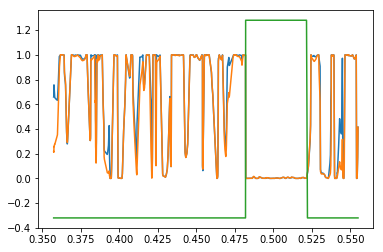

In [12]:
daRange = numpy.arange(5000,8000)
xs = recoMap[daRange]
plt.plot (xs, numpy.exp(posterior[daRange]))
plt.plot (xs, numpy.exp(origPost[0,daRange]))
plt.plot (xs, (truth[daRange]-0.2)*1.6)

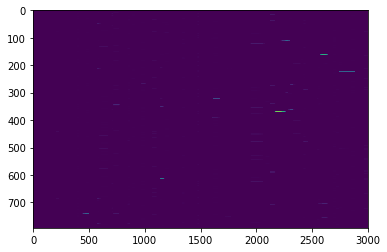

In [13]:
plt.imshow (numpy.exp(origPost[:,5000:8000]), aspect='auto')

#### Venture into new territory

In [14]:
# make it small for now, so we see what we are doing
# numHaps = 8
# numLoci = 12
# refHaps = refHaps[0:numHaps,0:numLoci]
# target = target[:,0:numLoci]
# recoMap = recoMap[0:numLoci]

# refHaps = refHaps[360:380,:]

In [15]:
# get the path right, for some reason cython makes trouble
sys.path.append("../../Python3/")
sys.path.append("../../Python3/Python3/")
sys.path.append("../../PackagesSupport/loadEigenstrat/")

In [16]:
from hmm_inference import HMM_Analyze
import msTransitions
import msEmissions
import msFun
import msHMM

In [17]:
importlib.reload(sys.modules["msTransitions"])
from msTransitions import rate_matrix_oneSL, exponentiate_rate_matrices, allele_frequencies
from msTransitions import one_step_transitions_reference, non_roh_state_map, non_roh_transition_matrices
from msTransitions import HW_transition_matrices, johnsQ
importlib.reload(sys.modules["msHMM"])
from msHMM import fancy_initial_distribution, stationary_inital_distribution, get_ROH_posterior
importlib.reload(sys.modules["msEmissions"])
from msEmissions import extended_genotype_emissions, extended_rc_emission_log, extended_binom_emission
importlib.reload(sys.modules["msFun"])
from msFun import extended_fwd_bkwd_fast

In [31]:
%%time
# set up all the necessary stuff
n_ref = refHaps.shape[0]
n_loci = refHaps.shape[1]

# prepare the recombination map
# fake using a member function of class HMM_Analyze
blub = type('', (), {})()
blub.r_map = recoMap
blub.output = False
r_map = HMM_Analyze.prepare_rmap (self=blub)

# transition rate matrix Q
# t_mat = new_calc_transitions (roh_in=100, roh_out=100, roh_jump=300)
# Q = rate_matrix_oneSL (in_S = 100, in_L = 2, out_S = 400, out_L = 10, roh_jump = 300)
Q = rate_matrix_oneSL (in_S = 100, in_L = 1, out_S = 400, out_L = 10, roh_jump = 300)
# Q = rate_matrix_oneSL (in_S = 100, in_L = 0, out_S = 100, out_L = 0, roh_jump = 300)
# Q = rate_matrix_oneSL (in_S = 0, in_L = 100, out_S = 0, out_L = 100, roh_jump = 300)
# Q = johnsQ (500, 100, 50)
# Q = numpy.zeros((6,6))
# marginal properbilities
f_marg = allele_frequencies (refHaps)

# initial distribution
# initial probability to copy from one individual
# init_d = numpy.log (fancy_initial_distribution (n_ref, f_marg[0], pi_s=1e-4, pi_l=1e-4))
# init_d = numpy.log (fancy_initial_distribution (n_ref, f_marg[0], pi_s=1e-4, pi_l=0))
# init_d = numpy.log (fancy_initial_distribution (n_ref, f_marg[0], pi_s=0, pi_l=1e-4))
# init_d = numpy.log (fancy_initial_distribution (n_ref, f_marg[0], pi_s=0.5, pi_l=0.5))
init_d = numpy.log (stationary_inital_distribution (n_ref, f_marg[0], Q))
    
# transition
transition_matrices = exponentiate_rate_matrices (rates=Q, rec_v=r_map)
# also need the allele frequencies
f_trans = one_step_transitions_reference (refHaps, f_marg)
# get transition matrices between the non-ROH states
non_roh_transitions = non_roh_transition_matrices (transition_matrices, f_trans, f_marg)
# non_roh_transitions = HW_transition_matrices (transition_matrices, f_marg)

# emission
# prepare the emissions for all loci
e_mat_geno = extended_genotype_emissions (refHaps, e_rate_ref=1e-3)
e_mat_full = numpy.log (extended_binom_emission (ob_stat=target, e_mat=e_mat_geno, e_rate=1e-2))
# just some checks
assert(numpy.max(e_mat_full) < 0) 

# get some posterior
(newPost, fwd, bwd, tot_ll) = extended_fwd_bkwd_fast (init_d=init_d, e_prob0=e_mat_full,
                                  t=transition_matrices, f_marg=f_marg, f_trans=f_trans,
                                  non_roh_transitions=non_roh_transitions, full=True)

# sum over the grouings of the states
rohPost = get_ROH_posterior (newPost)

Memory Usage Full:
Memory Usage: 5376.507904 mB
CPU times: user 36.6 s, sys: 3.44 s, total: 40 s
Wall time: 39.7 s


In [32]:
newPost.shape

(38032, 1588)

#### Plot ROH on whole chromosome

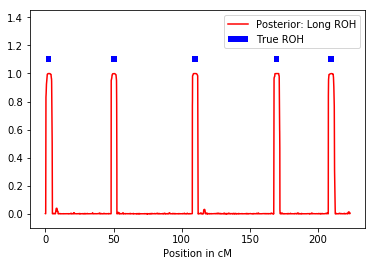

In [20]:
daRange = numpy.arange(0,38032)
xs = 100 * recoMap[daRange]
plt.plot (xs, rohPost[daRange,2], 'red')
plt.hlines (y=[1.1]*len(truthTable), xmin=100*truthTable["ROH_Begin"], xmax=100*truthTable["ROH_End"],
            colors="blue", linewidth=6)
plt.legend (["Posterior: Long ROH", "True ROH"])
plt.ylim([-0.1,1.45])
plt.xlabel ("Position in cM")
plt.savefig ("full_posterior.pdf")

#### Compare the different modes

In [21]:
zeroLpost = rohPost[:,2]

In [22]:
oneLpost = rohPost[:,2]

In [23]:
zeroLSpost = rohPost[:,2]

In [24]:
oneLSpost = rohPost[:,2]

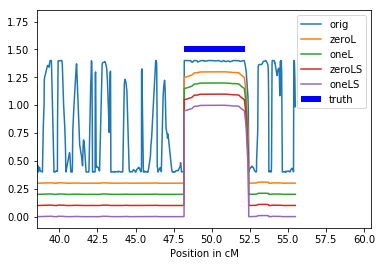

In [25]:
daRange = numpy.arange(5500,8000)
xs = 100 * recoMap[daRange]
plt.plot (xs, (1-numpy.exp(origPost[0,daRange]))+0.4)
plt.plot (xs, zeroLpost[daRange]+0.3)
plt.plot (xs, oneLpost[daRange]+0.2)
plt.plot (xs, zeroLSpost[daRange]+0.1)
plt.plot (xs, oneLSpost[daRange])
plt.hlines (y=[1.5]*len(truthTable), xmin=100*truthTable["ROH_Begin"], xmax=100*truthTable["ROH_End"],
            colors="blue", linewidth=6)
plt.legend (["orig", "zeroL", "oneL", "zeroLS", "oneLS", "truth"])
plt.ylim ([-0.1,1.85])
plt.xlim ([numpy.min(xs),numpy.max(xs)+5])
plt.xlabel ("Position in cM")
plt.savefig ("compare_models.pdf")

#### Show the three posterior states

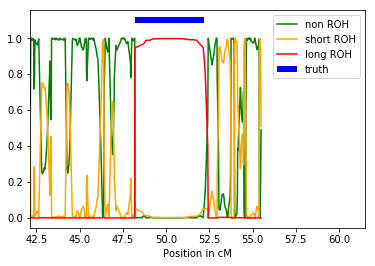

In [33]:
daRange = numpy.arange(6000,8000)
xs = 100 * recoMap[daRange]
plt.plot (xs, rohPost[daRange,0], "green")
plt.plot (xs, rohPost[daRange,1], "orange")
plt.plot (xs, rohPost[daRange,2], "red")
plt.hlines (y=[1.1]*len(truthTable), xmin=100*truthTable["ROH_Begin"], xmax=100*truthTable["ROH_End"],
            colors="blue", linewidth=6)
plt.xlim ([numpy.min(xs),numpy.max(xs)+6])
plt.legend (["non ROH", "short ROH", "long ROH", "truth"])
plt.xlabel ("Position in cM")
plt.savefig ("posterior_states.pdf")